# Laboratorium 3: Segmentacja obrazów

### Wprowadzenie
Segmentacja obrazów to proces podziału obrazu na regiony o podobnych cechach (np. jasności, kolorze, teksturze).
Celem segmentacji jest lokalizacja obiektów i ekstrakcja informacji w celu dalszej analizy.

Wyróżnia się kilka podstawowych podejść do segmentacji:
- **Progowanie globalne** (*thresholding*),
- **Progowanie adaptacyjne**,
- **Segmentacja oparta na krawędziach** (Sobel, Canny),
- **Segmentacja regionów** (Watershed).


### Wzory matematyczne

#### 1. Progowanie globalne
$$
I'(x,y) = 
\begin{cases}
1, & I(x,y) \geq T, \\
0, & I(x,y) < T,
\end{cases}
$$
gdzie $T$ – próg jasności.

#### 2. Progowanie adaptacyjne
$$
I'(x,y) = 
\begin{cases}
1, & I(x,y) \geq T(x,y), \\
0, & I(x,y) < T(x,y),
\end{cases}
$$
gdzie $T(x,y)$ zależy od lokalnego otoczenia piksela.

#### 3. Operator Sobela
$$
G = \sqrt{G_x^2 + G_y^2},
$$
gdzie
$$
G_x = I * S_x, \quad G_y = I * S_y,
$$
a $S_x, S_y$ to maski Sobela.


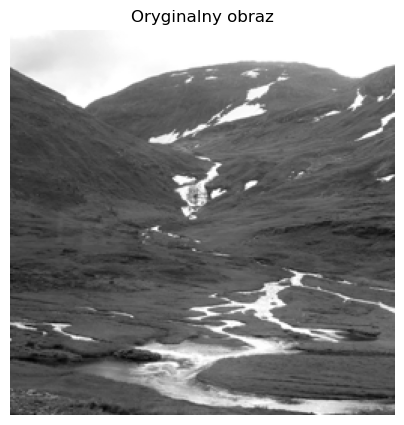

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Wczytanie obrazu w odcieniach szarości
image = cv2.imread("3.pgm", cv2.IMREAD_GRAYSCALE)
plt.figure(figsize=(5,5))
plt.imshow(image, cmap="gray")
plt.title("Oryginalny obraz")
plt.axis("off")
plt.show()

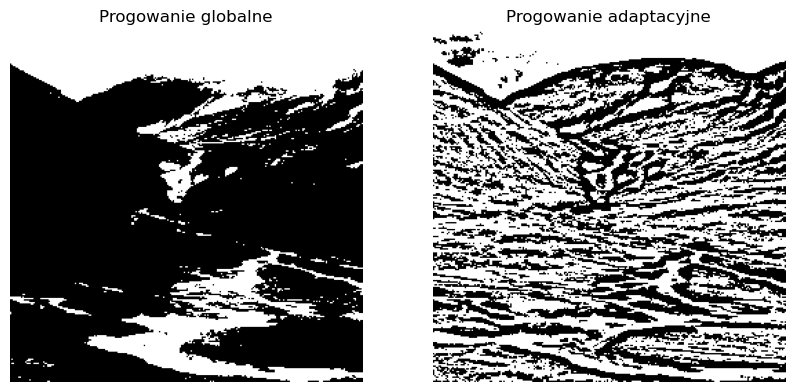

In [2]:
# Progowanie globalne
_, thresh_global = cv2.threshold(image, 127, 255, cv2.THRESH_BINARY)

# Progowanie adaptacyjne
thresh_adapt = cv2.adaptiveThreshold(image, 255, cv2.ADAPTIVE_THRESH_MEAN_C,
                                     cv2.THRESH_BINARY, 11, 2)

# Wizualizacja
fig, axes = plt.subplots(1, 2, figsize=(10,5))
axes[0].imshow(thresh_global, cmap="gray")
axes[0].set_title("Progowanie globalne")
axes[0].axis("off")

axes[1].imshow(thresh_adapt, cmap="gray")
axes[1].set_title("Progowanie adaptacyjne")
axes[1].axis("off")
plt.show()

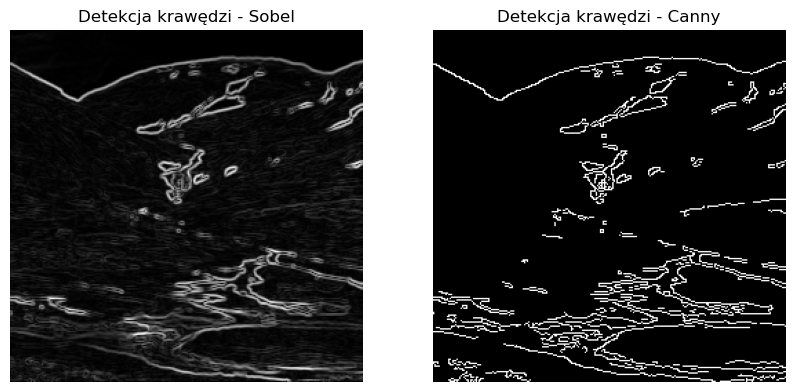

In [3]:
# Detektor Sobela
sobelx = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=3)
sobely = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=3)
sobel = cv2.magnitude(sobelx, sobely)

# Detektor Canny
canny = cv2.Canny(image, 100, 200)

# Wizualizacja
fig, axes = plt.subplots(1, 2, figsize=(10,5))
axes[0].imshow(sobel, cmap="gray")
axes[0].set_title("Detekcja krawędzi - Sobel")
axes[0].axis("off")

axes[1].imshow(canny, cmap="gray")
axes[1].set_title("Detekcja krawędzi - Canny")
axes[1].axis("off")
plt.show()

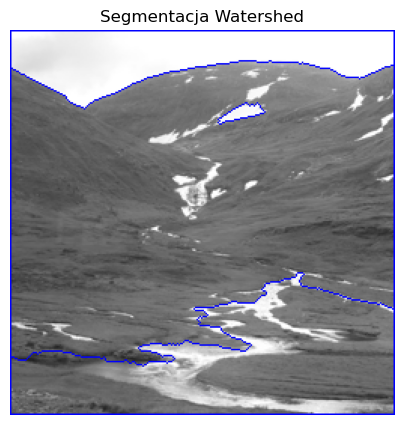

In [4]:
# Segmentacja Watershed
# Konwersja do BGR (wymagane przez algorytm)
image_color = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)

# Binaryzacja obrazu
_, binary = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

# Operacje morfologiczne
kernel = np.ones((3,3), np.uint8)
sure_bg = cv2.dilate(binary, kernel, iterations=3)
dist_transform = cv2.distanceTransform(binary, cv2.DIST_L2, 5)
_, sure_fg = cv2.threshold(dist_transform, 0.7*dist_transform.max(), 255, 0)

# Konwersja typów
sure_fg = np.uint8(sure_fg)
unknown = cv2.subtract(sure_bg, sure_fg)

# Etykietowanie
_, markers = cv2.connectedComponents(sure_fg)
markers = markers+1
markers[unknown==255] = 0

# Watershed
markers = cv2.watershed(image_color, markers)
image_color[markers == -1] = [255,0,0]

plt.figure(figsize=(5,5))
plt.imshow(cv2.cvtColor(image_color, cv2.COLOR_BGR2RGB))
plt.title("Segmentacja Watershed")
plt.axis("off")
plt.show()

### Podsumowanie
W tym laboratorium zastosowano różne techniki segmentacji obrazu:
- progowanie globalne i adaptacyjne,
- detekcję krawędzi (Sobel, Canny),
- segmentację opartą na regionach (Watershed).

Każda metoda ma inne właściwości – progowanie działa dobrze na obrazach o wyraźnym kontraście,
Sobel i Canny wydobywają krawędzie, a Watershed pozwala rozdzielać sąsiadujące obiekty.


Zadanie do wykonania

1. Przygotowanie danych: Wybierz zestaw obrazów, na których będą prowadzone eksperymenty w
zakresie segmentacji. Obrazy powinny zawierać różne obiekty, które mają zostać wyróżnione.
2. Segmentacja przy użyciu progowania: Zaimplementuj algorytmy progowania, takie jak
progowanie globalne i lokalne. Przetestuj różne wartości progów i oceniaj wyniki pod kątem
jakości segmentacji. Stosując różne wartości progów, można zobaczyć, jak wpływają na jakość
segmentacji obrazów. Wartości progów mogą być dostosowane do konkretnej aplikacji lub
rodzaju obiektów do segmentacji.
3. Segmentacja na podstawie kształtów: Wykorzystaj techniki segmentacji oparte na kształtach
obiektów, takie jak rozpoznawanie konturów i analiza kształtów obiektów. Zaimplementuj
algorytmy, które wykrywają obiekty o określonych kształtach, takie jak okręgi, prostokąty, lub
elipsy.
4. Segmentacja przy użyciu uczenia maszynowego: Stwórz model uczenia maszynowego, który
będzie w stanie dokładnie segmentować obiekty na obrazach. Możesz wykorzystać popularne
biblioteki do uczenia maszynowego, takie jak scikit-learn lub TensorFlow.

1. Przygotowanie środowiska

Import bibliotek

Wczytanie przykładowych obrazów

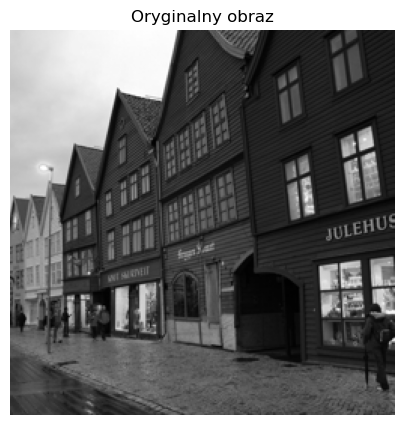

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage import filters, measure

# Funkcja pomocnicza do wyświetlania
def show_image(img, title="Obraz", cmap="gray"):
    plt.figure(figsize=(5,5))
    if len(img.shape) == 2:
        plt.imshow(img, cmap=cmap)
    else:
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title(title)
    plt.axis("off")
    plt.show()

# Wczytanie obrazu
image = cv2.imread("10s.png", cv2.IMREAD_GRAYSCALE)
show_image(image, "Oryginalny obraz")


2. Segmentacja przy użyciu progowania

Progowanie globalne (stały próg, Otsu)

Progowanie lokalne (adaptacyjne)

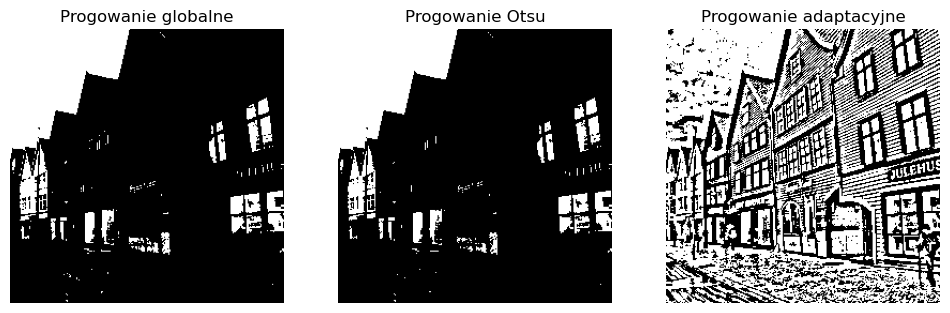

In [3]:
# Progowanie globalne
T = 128
_, global_thresh = cv2.threshold(image, T, 255, cv2.THRESH_BINARY)

# Otsu
_, otsu_thresh = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

# Adaptacyjne
adaptive_thresh = cv2.adaptiveThreshold(image, 255, cv2.ADAPTIVE_THRESH_MEAN_C,
                                        cv2.THRESH_BINARY, 11, 2)

# Wizualizacja
fig, axs = plt.subplots(1,3, figsize=(12,4))
axs[0].imshow(global_thresh, cmap="gray"); axs[0].set_title("Progowanie globalne")
axs[1].imshow(otsu_thresh, cmap="gray"); axs[1].set_title("Progowanie Otsu")
axs[2].imshow(adaptive_thresh, cmap="gray"); axs[2].set_title("Progowanie adaptacyjne")
for ax in axs: ax.axis("off")
plt.show()


3. Segmentacja na podstawie kształtów

Wykrywanie konturów

Analiza kształtów (prostokąty, koła, elipsy)

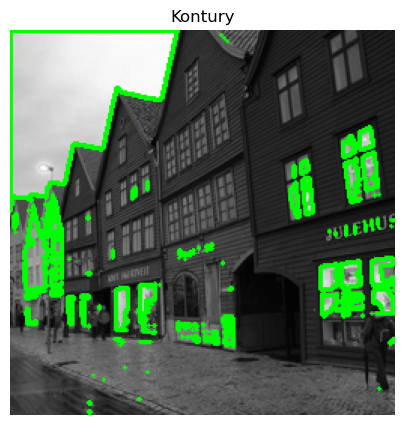

Kołowość: 0.5390120920947209
Kołowość: 0.0
Kołowość: 0.0
Kołowość: 0.0
Kołowość: 0.1849597093244486
Kołowość: 0.0929223300676956
Kołowość: 0.0
Kołowość: 0.4192316296468001
Kołowość: 0.0
Kołowość: 0.24626773441295843
Kołowość: 0.0
Kołowość: 0.21434290252196572
Kołowość: 0.0
Kołowość: 0.0
Kołowość: 0.0
Kołowość: 0.16122901519013072
Kołowość: 0.1367023277138338
Kołowość: 0.17083383857780127
Kołowość: 0.0
Kołowość: 0.09808208363663097
Kołowość: 0.0
Kołowość: 0.2486299159760465
Kołowość: 0.2573362529189966
Kołowość: 0.641141357875468
Kołowość: 0.3677539733755266
Kołowość: 0.06582975964058575
Kołowość: 0.19276314419912155
Kołowość: 0.0
Kołowość: 0.4860765901471373
Kołowość: 0.6662308698336755
Kołowość: 0.21434290252196572
Kołowość: 0.4248306390411815
Kołowość: 0.21393782543717227
Kołowość: 0.5390120952601716
Kołowość: 0.6462701752225273
Kołowość: 0.0
Kołowość: 0.6051155797957867
Kołowość: 0.2668865408085674
Kołowość: 0.0
Kołowość: 0.0
Kołowość: 0.0
Kołowość: 0.02766252551125515
Kołowość: 0.0

In [4]:
# Kontury
contours, _ = cv2.findContours(otsu_thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
img_contours = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
cv2.drawContours(img_contours, contours, -1, (0,255,0), 2)

show_image(img_contours, "Kontury")

# Analiza kształtów – kołowość
for cnt in contours:
    area = cv2.contourArea(cnt)
    perimeter = cv2.arcLength(cnt, True)
    if perimeter > 0:
        circularity = 4*np.pi*(area/(perimeter**2))
        print("Kołowość:", circularity)


4. Segmentacja przy użyciu uczenia maszynowego

Przykład z klasyfikacją pikseli (k-means):

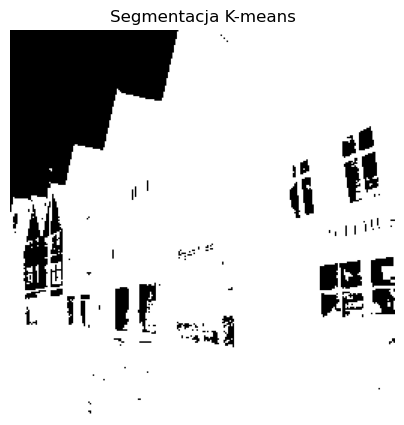

In [5]:
# K-means clustering dla segmentacji
Z = image.reshape((-1,1))
Z = np.float32(Z)
K = 2
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
_, labels, centers = cv2.kmeans(Z, K, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)
segmented = labels.reshape(image.shape)

show_image(segmented*127, "Segmentacja K-means")


4.Pytania kontrolne
1. Czym jest segmentacja obrazów i dlaczego jest istotna w przetwarzaniu obrazów?
2. Jakie są główne kategorie technik segmentacji obrazów, a w jakich przypadkach są one
stosowane?
3. Jak działa algorytm progowania w kontekście segmentacji obrazów? Jakie wyzwania może
stwarzać?
4. Jakie są różnice między progowaniem globalnym a progowaniem lokalnym? Kiedy warto
zastosować jedno z nich, a kiedy drugie?
5. Jakie są podstawowe etapy procesu segmentacji na podstawie kształtów obiektów? Jakie rodzaje
obiektów można wykryć przy użyciu tych technik?
6. Jakie są zalety i ograniczenia segmentacji opartej na kształtach obiektów w porównaniu z innymi
technikami?
7. Jakie są podstawowe zastosowania uczenia maszynowego w procesie segmentacji obrazów? Jakie
rodzaje modeli mogą być wykorzystane do tego celu?
8. Jakie są metryki oceny jakości segmentacji obrazów? Jakie wskaźniki pomagają ocenić
skuteczność segmentacji?
9. Jakie są wyzwania związane z segmentacją obrazów w zmieniających się warunkach
oświetleniowych lub w przypadku obiektów o złożonych kształtach?
10. Jakie są praktyczne zastosowania segmentacji obrazów w rzeczywistych systemach i aplikacjach,
takich jak rozpoznawanie twarzy, autonomiczne pojazdy lub medycyna?